Notebook Name: complete EDA and XGB baseline guide <br>
By: DATAMANYO

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv('data.csv')
df['x_e_out [-]'].isnull().sum()

10415

In [33]:
def summary(df):
    print(df.shape)
    summ = pd.DataFrame(df.dtypes,columns=['data type'])
    summ['#missing'] = df.isnull().sum()
    summ['%missing'] = df.isnull().sum() / len(df) *100
    summ['#unique'] = df.nunique()
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min']
    summ['max'] = desc['max']
    summ['first value'] = df.loc[0]
    summ['second value'] = df.loc[1]
    return summ

In [41]:
df_train = df[df['x_e_out [-]'].isnull()!=True]
df_train.reset_index(inplace=True,drop=True)

df_test = df[df['x_e_out [-]'].isnull()==True]
df_test.reset_index(inplace=True,drop=True)

In [46]:
summary(df_train)

(21229, 10)


,data type,#missing,%missing,#unique,min,max,first value,second value
id,int64,0,0.000000,21229,0.0,31643.0,0,1
author,object,3403,16.029959,10,NaN,NaN,Thompson,Thompson
geometry,object,3713,17.490226,3,NaN,NaN,tube,tube
pressure [MPa],float64,2986,14.065665,140,0.1,20.68,7.0,NaN
mass_flux [kg/m2-s],float64,3227,15.200904,689,0.0,7975.0,3770.0,6049.0
x_e_out [-],float64,0,0.000000,1682,-0.8667,0.232,0.1754,-0.0416
D_e [mm],float64,3641,17.151067,41,1.0,37.5,NaN,10.3
D_h [mm],float64,3127,14.729851,47,1.0,120.0,10.8,10.3
length [mm],float64,3157,14.871167,65,10.0,3048.0,432.0,762.0
chf_exp [MW/m2],float64,0,0.000000,109,0.8,19.3,3.6,6.2


In [47]:
summary(df_test)

(10415, 10)


,data type,#missing,%missing,#unique,min,max,first value,second value
id,int64,0,0.000000,10415,4.0,31642.0,4,7
author,object,1621,15.564090,10,NaN,NaN,NaN,Peskov
geometry,object,1787,17.157945,3,NaN,NaN,tube,tube
pressure [MPa],float64,1466,14.075852,118,0.1,20.68,13.79,18.0
mass_flux [kg/m2-s],float64,1564,15.016803,619,0.0,7975.0,686.0,750.0
x_e_out [-],float64,10415,100.000000,0,NaN,NaN,NaN,NaN
D_e [mm],float64,1847,17.734037,37,1.0,37.5,11.1,10.0
D_h [mm],float64,1462,14.037446,44,1.0,120.0,11.1,10.0
length [mm],float64,1602,15.381661,60,10.0,3048.0,457.0,1650.0
chf_exp [MW/m2],float64,0,0.000000,109,0.8,19.3,2.8,2.2


In [57]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.to_list()
num_cols.remove('id')
cat_cols = df.select_dtypes(include='object').columns.to_list()
all_feats = num_cols+cat_cols

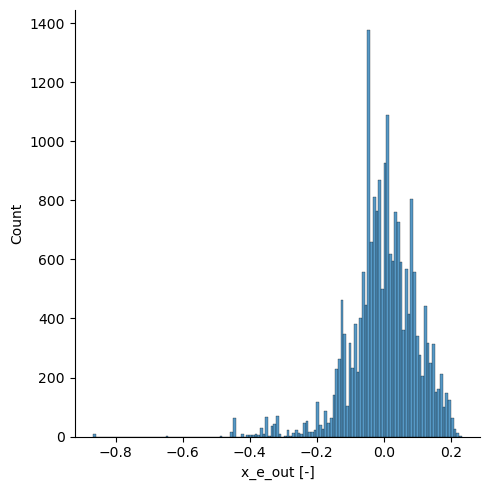

In [60]:
import seaborn as sns
import math
import matplotlib.pyplot as plt
sns.displot(df_train,x='x_e_out [-]')

C:\Users\ytaha\AppData\Local\Temp\ipykernel_20752\4293444085.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


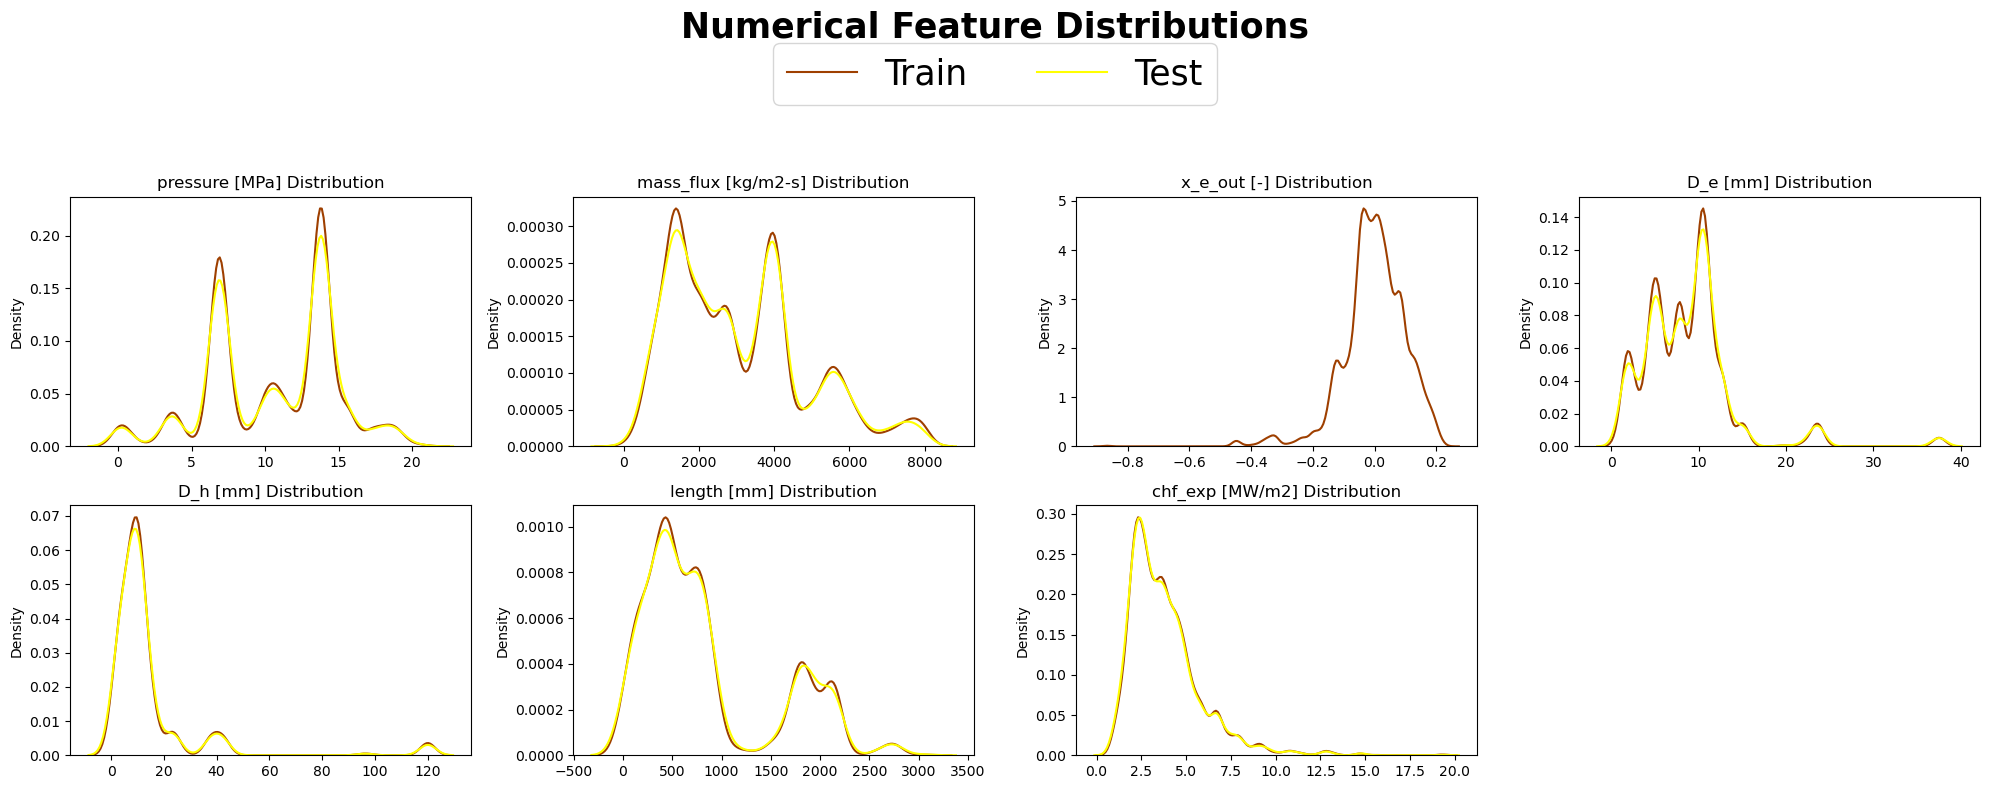

In [63]:
features = num_cols
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}
columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows,n_cols,figsize=(20,n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        df_train[column],label='Train',
        ax=ax[i], color ='#9E3F00'
    )
    
    sns.kdeplot(
        df_test[column], label='Test',
        ax=ax[i], color='yellow'
    )
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)

    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()

for i in range(i+1,len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Numerical Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()

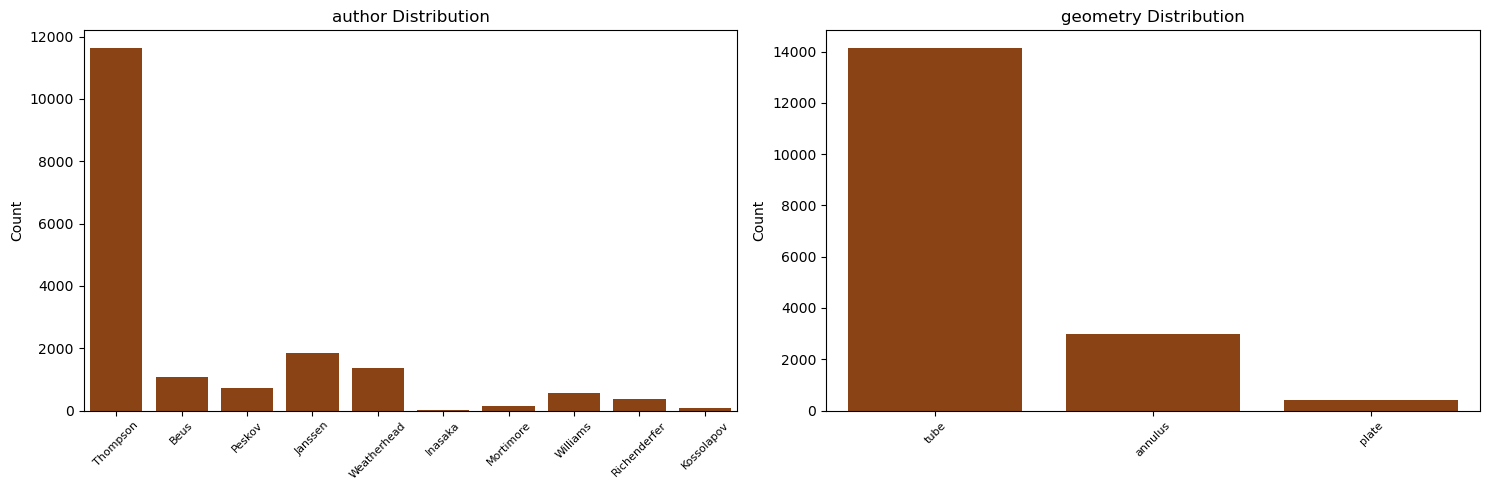

In [64]:
def plot_categorical_distribution(data,columns):
    n_cols = 2
    n_rows = math.ceil(len(columns)/n_cols)
    fig, ax = plt.subplots(n_rows,n_cols,figsize = (15,n_rows*5))
    if n_rows == 1:
        ax = ax.reshape(1,-1)
    
    for i,column in enumerate(columns):
        row_idx = i // n_cols
        col_idx = i % n_cols

        sns.countplot(data = data, x=column, ax = ax[row_idx,col_idx], color = '#9E3F00')
        #titles
        ax[row_idx,col_idx].set_title(f'{column} Distribution')
        ax[row_idx,col_idx].set_xlabel(None)
        ax[row_idx,col_idx].set_ylabel('Count')
        ax[row_idx,col_idx].tick_params(axis='x', labelrotation=45, labelsize=8)
    
    # remove empty subplots
    if len(columns) < n_rows * n_cols:
        for j in range(len(columns),n_rows*n_cols):
            fig.delaxes(ax[j//n_cols,j%n_cols])
    
    plt.tight_layout()
    plt.show()

plot_categorical_distribution(df_train,cat_cols)

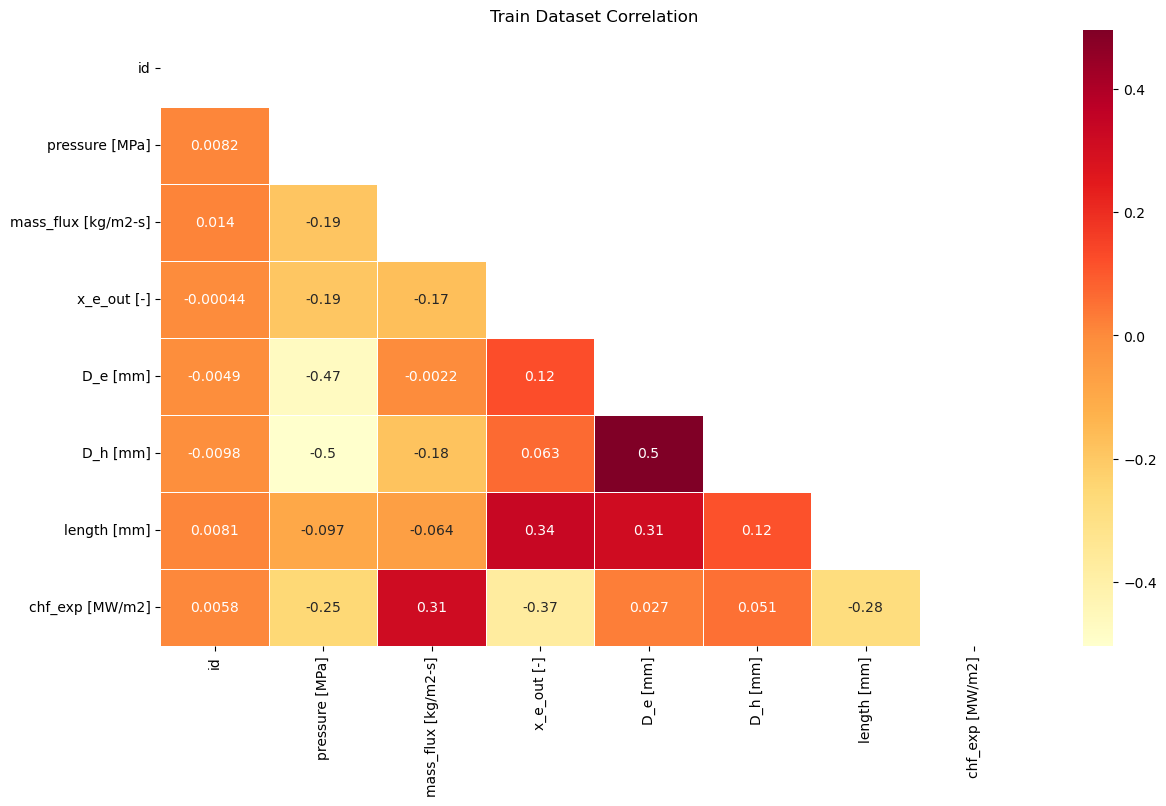

In [70]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str ='Train correcaltion') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(14,8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr,mask=mask,linewidths=.5,cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# plot_correlation_heatmap
plot_correlation_heatmap(df_train,'Train Dataset Correlation')
    

In [71]:
df_train = df_train[all_feats]


In [73]:
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
def preprocess_data(df,cat_cols,num_cols):
    # Copy the original dataframe to avoid modifying the original data
    processed_df = df.copy()

    # handling missing values in numerical variables
    num_imputer = SimpleImputer(strategy='mean')
    processed_df[num_cols] = num_imputer.fit_transform(processed_df[num_cols])

    # handling missing values in categorical variables
    cat_imputer = SimpleImputer(strategy='most_frequent')
    processed_df[cat_cols] = cat_imputer.fit_transform(processed_df[cat_cols])

    #Label encoding for categorical variables
    label_encoder = LabelEncoder()
    for col in cat_cols:
        processed_df[col] = label_encoder.fit_transform(processed_df[col])
    
    # Preprocess column names
    processed_df.columns = [re.sub(r'[\[\]<>\s]+', '_', col) for col in processed_df.columns]

    return processed_df

In [75]:
processed_df = preprocess_data(df_train,cat_cols=cat_cols,num_cols=num_cols)

In [80]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
cv_scores = list()
importance_xgb = list()
preds = list()

# Assuming 'train' is your DataFrame, and 'x_e_out_-_' is your target column
X = processed_df.drop('x_e_out_-_', axis=1)
Y = processed_df['x_e_out_-_']

## Running 3-fold CV
for i in range(3):
    print(f'\nFold {i+1} CV begins')
    skf = KFold(n_splits=3, random_state=np.random.randint(0,999), shuffle=True)
    
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        XGB_md = XGBRegressor(
                              objective='reg:squarederror',
                              colsample_bytree=0.8, 
                              gamma=0.8, 
                              learning_rate=0.01, 
                              max_depth=5, 
                              min_child_weight=10, 
                              n_estimators=1000, 
                              subsample=0.8).fit(X_train, Y_train)
        importance_xgb.append(XGB_md.feature_importances_)
        
        XGB_pred_1 = XGB_md.predict(X_test)
        rmse = mean_squared_error(Y_test, XGB_pred_1,squared=False)
        cv_scores.append(rmse)
        print(f'Fold {i+1} CV done. RMSE: \033[1;36m{rmse:.5f}\033[0m')

scores = np.mean(cv_scores)    
print(f'\nThe average RMSE over 3-folds (run 3 times) is: \033[1;36m{scores:.5f}\033[0m')


Fold 1 CV begins
Fold 1 CV done. RMSE: 0.08100
Fold 1 CV done. RMSE: 0.08220
Fold 1 CV done. RMSE: 0.08150

Fold 2 CV begins
Fold 2 CV done. RMSE: 0.08201
Fold 2 CV done. RMSE: 0.08167
Fold 2 CV done. RMSE: 0.08099

Fold 3 CV begins
Fold 3 CV done. RMSE: 0.08171
Fold 3 CV done. RMSE: 0.08038
Fold 3 CV done. RMSE: 0.08248

The average RMSE over 3-folds (run 3 times) is: 0.08155


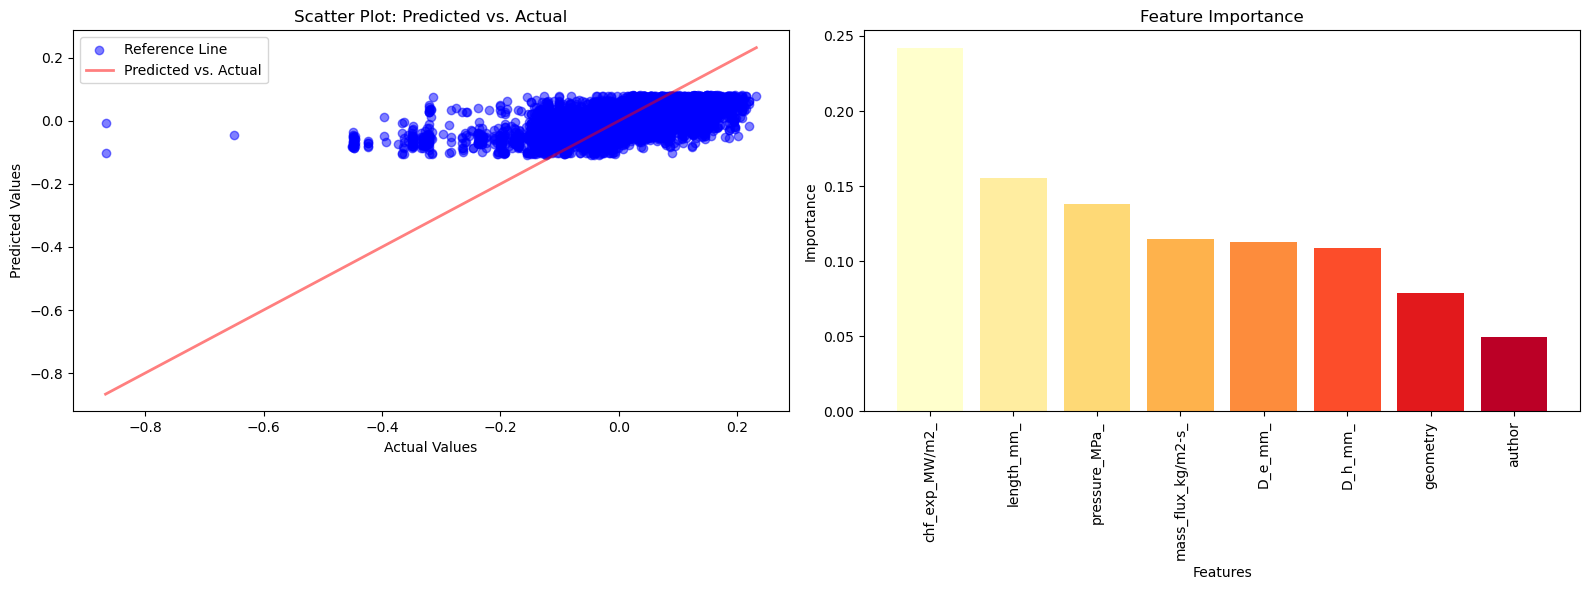

In [81]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming importance_xgb contains the feature importances from the XGB model
# Assuming preds contains the predictions from the XGB model

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot of actual values vs predicted values
axes[0].scatter(Y_test, XGB_pred_1, color='blue', label='Actual', alpha=0.5)
axes[0].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', alpha=0.5, linewidth=2)
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Scatter Plot: Predicted vs. Actual')
axes[0].legend(['Reference Line', 'Predicted vs. Actual'])

# Feature Importance visualization
importance_xgb_avg = np.mean(importance_xgb, axis=0)
sorted_feature_indices = np.argsort(importance_xgb_avg)[::-1]
sorted_feature_names = [X.columns[i] for i in sorted_feature_indices]
sorted_importance = importance_xgb_avg[sorted_feature_indices]

color_map = cm.get_cmap('YlOrRd')
colors = color_map(np.arange(len(sorted_feature_names)) / len(sorted_feature_names))

axes[1].bar(range(len(sorted_feature_names)), sorted_importance, color=colors)
axes[1].set_xticks(range(len(sorted_feature_names)))
axes[1].set_xticklabels(sorted_feature_names, rotation='vertical')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')
axes[1].set_title('Feature Importance')

plt.tight_layout()
plt.show()    